In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from os import listdir
from functools import wraps
from time import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json
import matplotlib as plt
import folium
try:
    import cPickle as pickle
except BaseException:
    import pickle

# Modeling
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Evaluation of the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error, median_absolute_error
from sklearn.metrics import r2_score#, mean_gamma_deviance# mean_poisson_deviance, mean_gamma_deviance

def timer(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start))
        return result
    return wrapper

# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



@timer
def get_date(base_dir):
    new_time = []
    for file in listdir(base_dir):
        file_path = f'{base_dir}/{file}'
        match=file.split("_")[1]
        date = pd.to_datetime(match, format = "%Y%m%d%H").strftime('%d/%m/%Y')
        time = (datetime.strptime(match, "%Y%m%d%H") + timedelta(hours=6)).strftime('%H:%M')
        new_time.append(date + " " + time)
    return new_time


@timer
def get_variables(base_dir, var_list, diccionario, nz=26):
  d3_var = ["HGTprs", "CLWMRprs", "RHprs","Velprs","UGRDprs","VGRDprs","TMPprs"]
  d2_var = ["HGTsfc", "MSLETmsl", "PWATclm", "RH2m", "Vel100m", "UGRD100m", "VGRD100m",
            "Vel80m", "UGRD80m", "VGRD80m", "Vel10m", "UGRD10m", "VGRD10m", "GUSTsfc",
            "TMPsfc", "TMP2m", "no4LFTXsfc", "CAPEsfc", "SPFH2m", "SPFH80m"]

  lst = []
  
  for file in listdir(base_dir):
    file_path = f'{base_dir}/{file}'
    e_file = []
    for key, value in diccionario.items():
    
      if key in set(var_list).intersection(d3_var): #d3_var:
        corte = value[0] + int(((value[1])/26)*nz)
        e_file.append(np.fromfile(file_path, dtype=np.float32)[value[0]:corte])

      elif key in set(var_list).intersection(d2_var):#d2_var:
        e_file.append(np.fromfile(file_path, dtype=np.float32)[value[0]:value[1]])
    lst.append(e_file)
  
  return lst

@timer
def setup_x(dataframe):
  """Flat variables values for model training"""
  dataframe.reset_index(level=0, inplace=True)
  row_list =[] 
  for index, rows in dataframe.iterrows(): 
      my_list = [rows.RHprs, rows.Velprs, rows.TMPprs, rows.Vel100m, rows.Vel80m,rows.TMPsfc, rows.SPFH80m]
      row_list.append(my_list) 

  a = [np.concatenate(row_list[i]) for i in range(len(row_list))]
  train_ = pd.DataFrame(a, index=dataframe["index"])
  return train_

In [0]:
# Data loading 
print("Reading the data...")
base_dir = '/content/drive/My Drive/datos/GFS_data'
power_csv = '/content/pow_data.csv'#
#power_csv="/content/power_data.csv"
gfs_dict_path = '/content/power_data.csv'

gfs_data_dict = {
 'CAPEsfc': [23283, 23400], 'CLWMRprs': [3042, 6084], 'GUSTsfc': [22815, 22932],
 'HGTprs': [0, 3042], 'HGTsfc': [21294, 21411], 'MSLETmsl': [21411, 21528], 'PWATclm': [21528, 21645],
 'RH2m': [21645, 21762], 'RHprs': [6084, 9126], 'SPFH2m': [23400, 23517], 'SPFH80m': [23517, 23634],
 'TMP2m': [23049, 23166], 'TMPprs': [18252, 21294], 'TMPsfc': [22932, 23049], 'UGRD100m': [21879, 21996],
 'UGRD10m': [22581, 22698], 'UGRD80m': [22230, 22347], 'UGRDprs': [12168, 15210], 'VGRD100m': [21996, 22113],
 'VGRD10m': [22698, 22815], 'VGRD80m': [22347, 22464], 'VGRDprs': [15210, 18252], 'Vel100m': [21762, 21879],
 'Vel10m': [22464, 22581], 'Vel80m': [22113, 22230], 'Velprs': [9126, 12168], 'no4LFTXsfc': [23166, 23283]
 }


Reading the data...


In [0]:

# Selection of variables and pre-processing
list_var = ["RHprs", "Velprs", "TMPprs", "Vel100m","Vel80m", "TMPsfc", "SPFH80m"]

lista_dates = get_date(base_dir)

variables_ready = get_variables(base_dir, list_var, gfs_data_dict, nz=5)

## Set as DF
#when slimbook
df_power = pd.read_csv(power_csv)
#df_power = pd.read_csv('/content/power_data.csv')#, encoding='utf8', sep='\t')
#when windows
df_power = pd.read_csv(power_csv, encoding='utf8', sep='\t')


df_gfs = pd.DataFrame(data=variables_ready, index=lista_dates, columns=list_var)
#df_power = pd.read_csv(power_csv, encoding='utf8')
df_power['date'] =  pd.to_datetime(df_power['date'], format='%d/%m/%Y %H:%M')
df_power = df_power.set_index("date")

df_gfs.sort_index(axis=0, level=None, ascending=True, inplace=True)
df_gfs = df_gfs.loc[:'31/12/2016 00:00']
df_power.sort_index(axis=0, level=None, ascending=True, inplace=True)
df_power = df_power.loc[:'31/12/2016 00:00']

Elapsed time: 20.98387360572815
Elapsed time: 2606.9707458019257


In [0]:
# df intersection based on dates
trained = df_power.merge(df_gfs, left_index=True, right_index=True) 

# Data preparation for model train
trained = df_power.merge(df_gfs, left_index=True, right_index=True) # df intersection based on dates

df_X = trained[[x for x in trained.columns if x != 'Production']]

X = setup_x(df_X)
y = pd.DataFrame(trained["Production"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Elapsed time: 9.598525285720825


In [0]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

#LGBMRegressor
gbm0 = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.1,
    n_estimators=1000)

print("Fitting LGBMRegressor model...")
gbm_fit = gbm0.fit(X_train, y_train, eval_metric='rmse')
print("Finished fitting LGBMRegressor model")

Fitting LGBMRegressor model...
Finished fitting LGBMRegressor model


In [0]:
# Prediction
predict_lightGBM = gbm0.predict(X_test)

y_trained = np.array(trained['Production'])
y_pred = predict_lightGBM
y_truth = np.array(y_test)
print('explained_variance_score', explained_variance_score(y_truth, y_pred))
print('max_error', max_error(y_truth, y_pred))
print('mean_absolute_error', mean_absolute_error(y_truth, y_pred))
print('mean_squared_error', mean_squared_error(y_truth, y_pred))
print('mean_squared_log_error', mean_squared_log_error(y_truth**2, y_pred**2))
print('median_absolute_error', median_absolute_error(y_truth, y_pred))
print('r2_score', r2_score(y_truth, y_pred))
print('rmse', rmse(y_truth, y_pred))



explained_variance_score 0.29043962199610385
max_error 169229.4844695173
mean_absolute_error 42396.972129664144
mean_squared_error 2888827639.8226266
mean_squared_log_error 70.51175845464078
median_absolute_error 34414.01404656979
r2_score 0.2896459877538511
rmse 53747.8152097611


In [0]:
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model_gbm = GridSearchCV(gbm0, optimization_dict, 
                     scoring='neg_mean_absolute_error', verbose=1)

model_gbm.fit(X_train, y_train)
print("GBM best score", model_gbm.best_score_)
print("GBM best params", model_gbm.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 22.7min finished


GBM best score -42349.12652737538
GBM best params {'max_depth': 6, 'n_estimators': 200}


In [0]:
num_train, num_feature = X_train.shape

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'mse',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# generate feature names
feature_name = ['feature_' + str(col) for col in range(num_feature)]

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train,  # eval training data
                feature_name=feature_name,
                categorical_feature=[21])

print('Finished first 10 rounds...')
print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Dumping model to JSON...')
# dump model to JSON (and save to file)
model_json = gbm.dump_model()

with open('model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

print('Loading model to predict...')
# load model to predict
bst = lgb.Booster(model_file='model.txt')
# can only predict with the best iteration (or the saving iteration)
y_pred = bst.predict(X_test)
# eval with loaded model 
print("The rmse of loaded model's prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

Starting training...


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 6.59782e+09
[2]	training's l2: 6.59782e+09
[3]	training's l2: 6.59782e+09
[4]	training's l2: 6.59782e+09
[5]	training's l2: 6.59782e+09
[6]	training's l2: 6.59782e+09
[7]	training's l2: 6.59782e+09
[8]	training's l2: 6.59782e+09
[9]	training's l2: 6.59782e+09
[10]	training's l2: 6.59782e+09
[11]	training's l2: 6.59782e+09
[12]	training's l2: 6.59782e+09
[13]	training's l2: 6.59782e+09
[14]	training's l2: 6.59782e+09
[15]	training's l2: 6.59782e+09
[16]	training's l2: 6.59782e+09
[17]	training's l2: 6.59782e+09
[18]	training's l2: 6.59782e+09
[19]	training's l2: 6.59782e+09
[20]	training's l2: 6.59782e+09
[21]	training's l2: 6.59782e+09
[22]	training's l2: 6.59782e+09
[23]	training's l2: 6.59782e+09
[24]	training's l2: 6.59782e+09
[25]	training's l2: 6.59782e+09
[26]	training's l2: 6.59782e+09
[27]	training's l2: 6.59782e+09
[28]	training's l2: 6.59782e+09
[29]	training's l2: 6.59782e+09
[30]	training's l2: 6.59782e+09
[31]	training's l2: 6.59782e+09
[32]	training's l

In [0]:
# dump model with pickle
with open('model.pkl', 'wb') as fout:
    pickle.dump(gbm, fout)
# load model with pickle to predict
with open('model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)
# can predict with any iteration when loaded in pickle way
y_pred = pkl_bst.predict(X_test, num_iteration=7)
# eval with loaded model
print("The rmse of pickled model's prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of pickled model's prediction is: 86209.45741192876


In [0]:
#################################################################
#################################################################
#################################################################

In [0]:
# SECOND ROUND
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lgb.train(params, lgb_train, 100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [0]:
#Prediction
y_pred=clf.predict(X_test)
#convert into binary values
for i in range(0,99):
  if y_pred[i]>=.5:       # setting threshold to .5
    y_pred[i]=1
  else:  
    y_pred[i]=0
print("The rmse of pickled model's prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of pickled model's prediction is: 86209.4440394231


100%|██████████| 500/500 [00:02<00:00, 210.41it/s, best loss: -0.24999965642266697]
{'x': 0.5005861547005761}


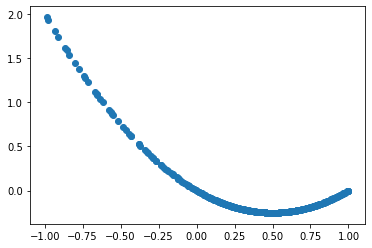

In [0]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt

# Define objective function
def f(x):
    return {'loss': x ** 2 - x, 'status': STATUS_OK}

# Run hyperopt optimization
trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=hp.uniform('x', -1, 1),   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=500,                  # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)

# Print the optimized parameters
print(result)   # {'x': 0.5000833960783931}

# Extract and plot the trials 
x = trials.vals['x']
y = [x['loss'] for x in trials.results]
plt.scatter(x, y)

In [0]:

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [0]:
import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

@timer

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [0]:
obj = HPOpt(X_train, X_test, y_train, y_test)
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

Elapsed time: 5.7220458984375e-06
[11:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:18:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:19:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:19:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:21:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linea

In [0]:
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [1:52:11<00:00, 68.13s/it, best loss: 51753.51522429675]


In [0]:
!pip install hpsklearn

     |████████████████████████████████| 163kB 12.9MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-cp36-none-any.whl size=23913 sha256=463b143e8394f987ec4743eaf9da44e22f27308ea8a813cedfebcc61eea4c782
  Stored in directory: /root/.cache/pip/wheels/41/ee/c4/3c267cbf78f0905434ee36b915d97a20610ad3af7ff3c75852
Successfully built hpsklearn


In [0]:
from hpsklearn import HyperoptEstimator, any_classifier
#from sklearn.datasets import fetch_mldata
from hyperopt import tpe
import numpy as np


# Download the data and split into training and test sets
#digits = fetch_mldata('MNIST original')

#X = digits.data
#y = digits.target

#test_size = int( 0.2 * len( y ) )
#np.random.seed(seed)
#indices = np.random.permutation(len(X))
#X_train = X[indices[:-test_size]]
#y_train = y[indices[:-test_size]]
#X_test  = X[indices[-test_size:]]
#y_test  = y[indices[-test_size:]]

estim = HyperoptEstimator(classifier=any_classifier('clf'),  
                          algo=tpe.suggest, 
                          trial_timeout=300)

estim.fit(X_train, y_train)

print(estim.score( X_test, y_test ))
# <<show score here>>
print(estim.best_model())

## https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]


KeyError: ignored